# Single-Model Learning

In [1]:
import matplotlib.pyplot as plt
import numpy
import pandas

# See https://keras.io/
# for extennsive documentation
import tensorflow as tf
from tensorflow import keras
from keras import layers


from keras.models import Sequential
from keras.layers import Dense

import sklearn.utils

import pickle
def fnSaveObject(save_object, sFileName):
    with open(sFileName, "wb") as file:
        pickle.dump(save_object, file)

def fnLoadObject(sFileName):
    with open(sFileName, 'rb') as file:
        load_object = pickle.load(file)
    return load_object

2023-03-25 19:13:50.292575: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
# load all examples from the file
data_x_pandas = fnLoadObject('training_data/train_sphere_x.dat')
data_y_pandas = fnLoadObject('training_data/train_sphere_y.dat')

# post-process y-values
data_x2 = numpy.empty(shape=(len(data_y_pandas), 2))
for i, frame in enumerate(data_y_pandas):
    data_x2[i, 0] = frame.loc[frame.par =='scale', 'value'].squeeze()
    data_x2[i, 1] = frame.loc[frame.par =='sld_solvent', 'value'].squeeze()

    index_names = frame[ frame['par'] == 'scale'].index
    frame.drop(index_names, inplace = True)
    index_names = frame[ frame['par'] == 'sld_solvent'].index
    frame.drop(index_names, inplace = True)

print(data_y_pandas[0])

data_x = numpy.row_stack([frame['I'].to_numpy() for frame in data_x_pandas]).astype('float32')
data_x = numpy.log10(data_x)
data_x2 = data_x2.astype('float32')
data_y = numpy.row_stack([frame['value'].to_numpy() for frame in data_y_pandas]).astype('float32')

print("data_x:", data_x.shape)
print("data_y:", data_y.shape)
len_set = data_x.shape[0]
len_train = int(len_set * 2 / 3)

# Prepare for proper training
# randomly sort examples
data_x, data_x2, data_y = sklearn.utils.shuffle(data_x, data_x2, data_y, random_state=0)

# take the first 2/3 of examples for training
X_train = [data_x[:len_train, :], data_x2[:len_train, :]]
y_train = data_y[:len_train, :]

# and the remaining examples for testing
X_test = [data_x[len_train:, :], data_x2[len_train:, :]] # all features except last column
y_test = data_y[len_train:, :] # quality column

print("First example:")
print("Features:", X_train[0][0], X_train[1][0])
print("Quality:", y_train[0])

      par       value
0  radius  163.677147
2     sld    5.458123
data_x: (10000, 105)
data_y: (10000, 2)
First example:
Features: [ 1.6188699   1.6161623   1.5983831   1.5826792   1.560554    1.5295036
  1.4927766   1.4773812   1.4556102   1.4087521   1.3791335   1.3332375
  1.3012139   1.242085    1.1848094   1.1497346   1.0794678   1.0041676
  0.93627864  0.8459183   0.7440869   0.6428165   0.51670605  0.36628672
  0.23866801 -0.02124676 -0.14264296 -0.45699915 -0.50225276 -0.83889365
 -0.569426   -0.53088015 -0.40990743 -0.45569625 -0.5105077  -0.3453201
 -0.36823586 -0.5038429  -0.49285433 -0.85347664 -1.0836521  -0.9973829
 -1.0835958  -1.6024815  -1.0869004  -1.0947794  -1.1046101  -1.1067694
 -1.1717786  -1.2229795  -1.2238303  -1.2380505  -1.4601737  -1.5248673
 -1.2502844  -1.7233016  -1.3889087  -1.5447065  -1.4605925  -1.5990623
 -3.4829533  -1.5041051  -1.5331148  -1.838512   -1.5506166  -1.5389274
 -1.3850578  -2.0771618  -1.4261278  -2.1258426  -1.7222929  -1.6924813
 -1

In [12]:
# model construction
input1_dim = data_x.shape[1]
input2_dim = data_x2.shape[1]
n_input_layers = 4
n_branch_layers = 4
output_layers = []

node_n = input1_dim
node_n2 = input1_dim + input2_dim

activation = "relu"
reg_strategy = keras.regularizers.l1_l2(l1=0.001, l2=0.001)  # use L1 and L2 regularization

# common input layers
sans_input = keras.Input(shape=(input1_dim, ))
x = layers.Dense(node_n, activation=activation, kernel_regularizer=reg_strategy)(sans_input)
for _ in range(n_input_layers-1):
    x = layers.Dense(node_n, activation=activation, kernel_regularizer=reg_strategy)(x)

par_input = keras.Input(shape=(input2_dim, ))
x2 = layers.Dense(input2_dim, activation=activation, kernel_regularizer=reg_strategy)(par_input)

x3 = layers.concatenate([x, x2])
for i in range(n_branch_layers):
    x3 = layers.Dense(node_n2, activation=activation, kernel_regularizer=reg_strategy)(x3)
output_layer = Dense(data_y.shape[1], activation="linear")(x3)

#model
model = keras.Model(
    inputs=[sans_input, par_input],
    outputs=output_layer,
)

opt = keras.optimizers.Adam(learning_rate=0.0005)
model.compile(loss="mse",
              optimizer=opt
             )

print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 105)]        0           []                               
                                                                                                  
 dense_50 (Dense)               (None, 105)          11130       ['input_13[0][0]']               
                                                                                                  
 dense_51 (Dense)               (None, 105)          11130       ['dense_50[0][0]']               
                                                                                                  
 dense_52 (Dense)               (None, 105)          11130       ['dense_51[0][0]']               
                                                                                            

In [13]:
epochs_n = 500
batch_size = 16

save_period = 20  # after how many epochs the model should be saved?
chkpnt_saver = keras.callbacks.ModelCheckpoint("weights-{epoch:02d}.hdf5", save_weights_only=True, save_freq=save_period)


history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=epochs_n,
                    batch_size=batch_size,
                    verbose=1
                    )

# callbacks=[chkpnt_saver])

Epoch 1/500
417/417 [==============================] - 3s 3ms/step - loss: 642.0486 - val_loss: 77.1047
Epoch 2/500
417/417 [==============================] - 1s 3ms/step - loss: 61.2465 - val_loss: 59.7571
Epoch 3/500
417/417 [==============================] - 1s 2ms/step - loss: 60.4136 - val_loss: 45.7428
Epoch 4/500
417/417 [==============================] - 1s 2ms/step - loss: 56.5793 - val_loss: 48.0793
Epoch 5/500
417/417 [==============================] - 1s 3ms/step - loss: 53.6161 - val_loss: 37.8674
Epoch 6/500
417/417 [==============================] - 1s 3ms/step - loss: 51.4896 - val_loss: 44.5517
Epoch 7/500
417/417 [==============================] - 1s 3ms/step - loss: 50.4264 - val_loss: 45.4070
Epoch 8/500
417/417 [==============================] - 1s 3ms/step - loss: 50.5365 - val_loss: 39.4246
Epoch 9/500
417/417 [==============================] - 1s 3ms/step - loss: 49.5301 - val_loss: 47.4139
Epoch 10/500
417/417 [==============================] - 1s 3ms/step - lo

In [14]:
# The history object returned by the model training above
# contains the values of the loss function (the mean-squared-error)
# at different epochs
# We discard the first epoch as the loss value is very high,
# obscuring the rest of the distribution
train_loss = history.history["loss"][1:]
test_loss = history.history["val_loss"][1:]

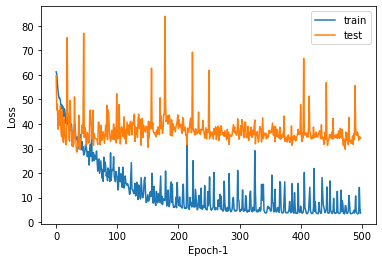

In [15]:
# Prepare and plot loss over time
plt.plot(train_loss,label="train")
plt.plot(test_loss,label="test")
plt.legend()
plt.xlabel("Epoch-1")
plt.ylabel("Loss")
plt.show()

In [16]:
# After the training:

# Prepare scatter plot
y_pred = model.predict(X_test)


105/105 [==============================] - 0s 1ms/step


radius
Correlation coefficient: [[1.         0.98976083]
 [0.98976083 1.        ]]


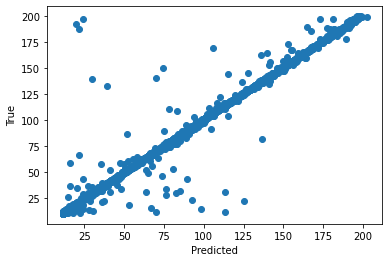

sld
Correlation coefficient: [[1.         0.75322686]
 [0.75322686 1.        ]]


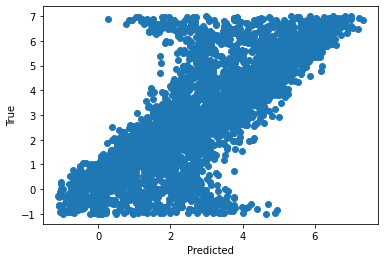

In [17]:
for i in range(y_pred.shape[1]):
    print(data_y_pandas[0]['par'].iloc[i])
    print("Correlation coefficient:", numpy.corrcoef(y_pred[:, i],y_test[:, i]))
    plt.scatter(y_pred[:, i],y_test[:, i])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()